In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf

import numpy as np
import pandas as pd
import pandas_datareader.data as pdr


from pandas_datareader import data as pdr
import datetime

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Input Section

In [3]:
Tickers_total=['TSM','ADBE','COST','KKR','CSCO','UNH','VRTX']
start_date = '01-01-2016'
end_date = '27-06-2022'

global riskFreeRate
riskFreeRate=0.02

global Tickers_Sectorwise
Tickers_Sectorwise={'Tech':['TSM','ADBE','CSCO'],'Healthcare':['UNH','VRTX'],'Financials':['KKR'],'RealEstate':[],'ConsumerStaples':['COST'],'ConsumerDiscretionary':[],'Energy':[],'Industrials':[]}

Sector_Constraints={'Tech':[0.1,0.3],'Healthcare':[0.05,0.15],'Financials':[0.05,0.15],'RealEstate':[0.05,0.15],'ConsumerStaples':[0.05,0.15],'ConsumerDiscretionary':[0.05,0.15],'Energy':[0.05,0.15],'Industrials':[0.05,0.15]}

# Functions

### Minor Functions

In [4]:
def convertPricetoReturn(HistoricalData_price,tickers):
  logPrice=np.log(HistoricalData_price)
  HistoricalData_returns=logPrice[1:,:]-logPrice[:-1,:]
  return pd.DataFrame(HistoricalData_returns,columns=tickers)

In [5]:
def Get_Portfolio_Tickers_Sectorwise_and_SectorwiseCount(Portfolio_Tickers):
  Portfolio_Tickers_Sectorwise={}
  SectorwiseCount={}
  for i in Portfolio_Tickers:
    for j in Tickers_Sectorwise:
      if j not in SectorwiseCount.keys():
        SectorwiseCount.update({j:0})
      if i in Tickers_Sectorwise[j]:
        Portfolio_Tickers_Sectorwise.update({i:j})
        SectorwiseCount[j]+=1
      

  return [Portfolio_Tickers_Sectorwise,SectorwiseCount]

### Getting Historical Data

In [6]:
def getHistoricalData_AdjClose(Ticker_List,Start,End):
  data=[]
  daily_prices_list=[]
  data_final= pd.DataFrame()
  yf.pdr_override()
  
  if isinstance(Start,str):
    Start = datetime.datetime.strptime(Start, '%d-%m-%Y')
  if isinstance(End,str):
    End = datetime.datetime.strptime(End, '%d-%m-%Y')
  for i,k in enumerate(Ticker_List):
    try:
      data_input=(pdr.get_data_yahoo(k, data_source='yahoo', start=Start, end=End)['Adj Close'])
      data_final[k]=data_input
    except Exception:
      print('Not found',k)
      pass
  
  return data_final

### Getting randomized weights

In [7]:
def getRandomWeights(Portfolio_Tickers_Sectorwise,Sector_Constraints={},sectorwiseCount={}):
  if len(Sector_Constraints)==0:
    return np.array(np.random.random(size=len(Portfolio_Tickers_Sectorwise.keys())))

  randomlist=[]
  for i in Portfolio_Tickers_Sectorwise.keys():
    randomlist.append(np.random.uniform(Sector_Constraints[Portfolio_Tickers_Sectorwise[i]][0],Sector_Constraints[Portfolio_Tickers_Sectorwise[i]][1])/sectorwiseCount[Portfolio_Tickers_Sectorwise[i]])
  
  return np.array(randomlist)
  

  
  

### Monte Carlo Simulation

In [30]:
def Port_Optimizer_MonteCarlo(Portfolio_Tickers,expected_returns,covariance_matrix,sector_constraints={},current_weights=[],num=0,returnWeightsOnly=False):
  if num==0:
    num=min(10**(len(Portfolio_Tickers)),100000)
  
  [Portfolio_Tickers_Sectorwise,sectorwiseCount]=Get_Portfolio_Tickers_Sectorwise_and_SectorwiseCount(Portfolio_Tickers)

# initialize weight allocation to be all zeros (for each simulation)
  init_weights_sim = np.zeros((num, len(Portfolio_Tickers)))

# initialize returns to be all zeros (for each simulation)
  stock_returns_sim = np.zeros(num)

# initialize volatility to be all zeros (for each simulation)
  vol_sim = np.zeros(num)

# initialize Sharpe Ratio to be all zeros (for each simulation)
  sharpe_ratio_sim = np.zeros(num)

  print("Running Simulation Now:--->\n")
  
  for i in range(num):
    weights_sim = getRandomWeights(Portfolio_Tickers_Sectorwise,sector_constraints,sectorwiseCount)

    weights_sim = weights_sim / np.sum(weights_sim)
    
    
    init_weights_sim[i, :] = weights_sim # store the random weight allocation of this simulation run

    
    stock_returns_sim[i] = np.sum((expected_returns * weights_sim) *252) # calculate expected returns 

    
    vol_sim[i] = np.sqrt(np.dot(weights_sim.T, np.dot(covariance_matrix * 252, weights_sim))) # calculate portfolio standard deviation

    
    sharpe_ratio_sim[i] = (stock_returns_sim[i]-riskFreeRate)/vol_sim[i] # calculating Sharpe Ratio
    
    if i % (num/10) == 0:
        print(f"epoch {i}/{num}: Complete")
    
  print("Done")
  if returnWeightsOnly== True:

    return init_weights_sim[sharpe_ratio_sim.argmax(),:]
  
  return [init_weights_sim,stock_returns_sim,vol_sim,sharpe_ratio_sim]

### Backtest Function

In [9]:
def backtest_Optimizer(Portfolio_tickers,Sector_Constraints,Benchmark="SP500",Backtest_duration=10,Rebalance_period=365,n=100000):
  BenchmarkDict={"SP500":[["^GSPC"],[1]],"NASDAQ100":[["^NDX"],[1]],"60/40":[0,[0.6,0.4]]}
  if Benchmark not in BenchmarkDict.keys():
    print(f"Invalid Benchmark. List of Available Benchmarks:{BenchmarkDict.keys()}")
  
  Start=datetime.datetime(datetime.datetime.now().year-Backtest_duration,1,1)
  End=datetime.datetime.now()
  Benchmark_ticker=BenchmarkDict[Benchmark][0]
  Benchmark_weights=np.array(BenchmarkDict[Benchmark][1])
  BenchmarkReturns=[0]

  Backtest_data=getHistoricalData_AdjClose(Portfolio_tickers,Start,End)
  BenchmarkData=getHistoricalData_AdjClose(Benchmark_ticker,Start,End)

  Portfolio_value=[1]
  Portfolio_returns_list=[0]
  Portfolio_weights_historical=[]

  start=np.array(Backtest_data.iloc[0])
  b_start=np.array(BenchmarkData.iloc[0])
  
  for i in range(0,len(Backtest_data)-1):

    if i%Rebalance_period==0:
      Rebalance_data=getHistoricalData_AdjClose(Portfolio_Tickers,pd.Timestamp(year=Backtest_data.index[i].year-3,month=1,day=1),Backtest_data.index[i])
      Expected_Returns=np.array(Rebalance_data.mean())
      Covariance_Matrix=np.array(Rebalance_data.cov())
      Portfolio_weights=Port_Optimizer_MonteCarlo(Portfolio_tickers,Expected_Returns,Covariance_Matrix,Sector_Constraints,num=n,returnWeightsOnly=True)
      Portfolio_weights_historical.append(Portfolio_weights)
      print(Portfolio_weights_historical)
    
    if Backtest_data.index[i+1].month!=Backtest_data.index[i].month:
      temp=np.array(Backtest_data.iloc[i])
      Stock_Returns=np.log(temp)-np.log(start)
      start=temp
      Portfolio_returns=np.dot(Portfolio_weights,Stock_Returns)
      Portfolio_returns_list.append(Portfolio_returns)

      b_temp=np.array(BenchmarkData.iloc[i])
      BenchmarkReturns.append(np.dot(Benchmark_weights,np.log(b_temp)-np.log(b_start)))
      b_start=b_temp

  
  return [Portfolio_returns_list,Portfolio_weights_historical,BenchmarkReturns]



## Runtime Code


### Historical Price Data and returns

In [10]:
HistoricalPriceData=getHistoricalData_AdjClose(Tickers_total,start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
HistoricalPriceData.head()


,TSM,ADBE,COST,KKR,CSCO,UNH,VRTX
Date,,,,,,,
2016-01-04,18.029858,91.970001,140.122910,13.433231,21.543219,105.460762,122.889999
2016-01-05,17.915585,92.339996,140.465424,13.152308,21.445330,105.659981,123.449997
2016-01-06,17.417702,91.019997,139.165604,12.888412,21.216928,104.582375,122.230003
2016-01-07,17.221815,89.110001,135.977386,12.335074,20.727491,101.503510,114.959999
2016-01-08,16.985119,87.849998,133.597168,12.054151,20.213593,99.755768,110.709999


In [12]:
HistoricalPriceData.tail()

,TSM,ADBE,COST,KKR,CSCO,UNH,VRTX
Date,,,,,,,
2022-06-17,85.000000,360.790009,445.920319,45.180000,43.002953,452.059998,263.089996
2022-06-21,86.949997,362.989990,462.311981,46.369999,43.746262,480.320007,270.170013
2022-06-22,84.910004,365.329987,459.167419,45.820000,43.181347,489.679993,272.309998
2022-06-23,84.120003,376.640015,474.181519,46.389999,42.547058,499.809998,283.500000
2022-06-24,85.919998,387.720001,483.535370,48.570000,43.706619,495.640015,292.549988


In [13]:
HistoricalReturnsData=convertPricetoReturn(HistoricalPriceData.to_numpy(copy=True),HistoricalPriceData.columns)

In [14]:
HistoricalReturnsData.mean()

TSM     0.000958
ADBE    0.000883
COST    0.000760
KKR     0.000789
CSCO    0.000434
UNH     0.000949
VRTX    0.000532
dtype: float64

### Variance-Covariance Matrix

In [15]:
HistoricalReturnsData.cov()

,TSM,ADBE,COST,KKR,CSCO,UNH,VRTX
TSM,0.000376,0.000215,0.000096,0.000207,0.000151,0.000124,0.000136
ADBE,0.000215,0.000434,0.000143,0.000244,0.000187,0.000156,0.000203
COST,0.000096,0.000143,0.000198,0.000118,0.000110,0.000099,0.000089
KKR,0.000207,0.000244,0.000118,0.000512,0.000182,0.000175,0.000169
CSCO,0.000151,0.000187,0.000110,0.000182,0.000288,0.000132,0.000149
UNH,0.000124,0.000156,0.000099,0.000175,0.000132,0.000291,0.000143
VRTX,0.000136,0.000203,0.000089,0.000169,0.000149,0.000143,0.000518


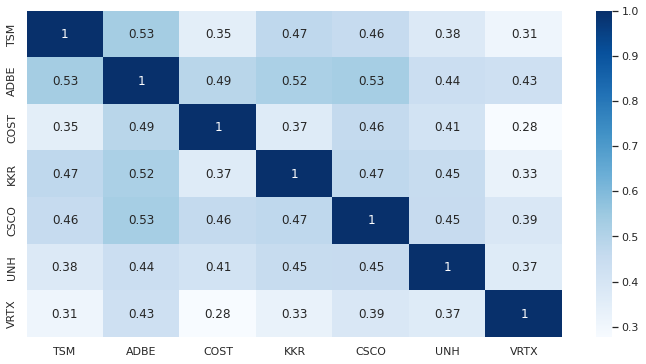

In [16]:
sns.set()
plt.figure(figsize=(12,6))
sns.heatmap(HistoricalReturnsData.corr(), annot = True, cmap = 'Blues')

### Running the Simulation

In [17]:
Portfolio_Tickers=['TSM','ADBE','COST','KKR','UNH','VRTX']
[Portfolio_Tickers_Sectorwise,sectorwiseCount]=Get_Portfolio_Tickers_Sectorwise_and_SectorwiseCount(Portfolio_Tickers)
print(Portfolio_Tickers_Sectorwise)
print(sectorwiseCount)


{'TSM': 'Tech', 'ADBE': 'Tech', 'COST': 'ConsumerStaples', 'KKR': 'Financials', 'UNH': 'Healthcare', 'VRTX': 'Healthcare'}
{'Tech': 2, 'Healthcare': 2, 'Financials': 1, 'RealEstate': 0, 'ConsumerStaples': 1, 'ConsumerDiscretionary': 0, 'Energy': 0, 'Industrials': 0}


In [18]:
Historical_Expected_Returns=np.array(HistoricalReturnsData[Portfolio_Tickers].mean())
Historical_Covariance_Matrix=np.array(HistoricalReturnsData[Portfolio_Tickers].cov())

In [31]:
[Weights,Returns,Variance,Sharpe]=Port_Optimizer_MonteCarlo(Portfolio_Tickers,Historical_Expected_Returns,Historical_Covariance_Matrix,Sector_Constraints,num=1000000)

Running Simulation Now:--->

epoch 0/1000000: Complete
epoch 100000/1000000: Complete
epoch 200000/1000000: Complete
epoch 300000/1000000: Complete
epoch 400000/1000000: Complete
epoch 500000/1000000: Complete
epoch 600000/1000000: Complete
epoch 700000/1000000: Complete
epoch 800000/1000000: Complete
epoch 900000/1000000: Complete
Done


In [32]:
np.set_printoptions(2)
print(f"Largest Sharpe Ratio Value: {Sharpe.max()}")
print(f"Largest Sharpe Ratio Index Location: {Sharpe.argmax()}")
print(f"Stock Universe: {Portfolio_Tickers}")
print(f"Optimal Weights: {Weights[Sharpe.argmax(),:]}") 

optimal_sr_return_sim = Returns[Sharpe.argmax()]
optimal_sr_vol_sim = Variance[Sharpe.argmax()]

print(f"Optimal Sharpe Ratio Return: {optimal_sr_return_sim}")
print(f"Optimal Sharpe Ratio Volatility: {optimal_sr_vol_sim}")

Largest Sharpe Ratio Value: 0.9234890879422994
Largest Sharpe Ratio Index Location: 600036
Stock Universe: ['TSM', 'ADBE', 'COST', 'KKR', 'UNH', 'VRTX']
Optimal Weights: [0.26 0.12 0.31 0.11 0.15 0.06]
Optimal Sharpe Ratio Return: 0.21261654903298188
Optimal Sharpe Ratio Volatility: 0.20857479698235132


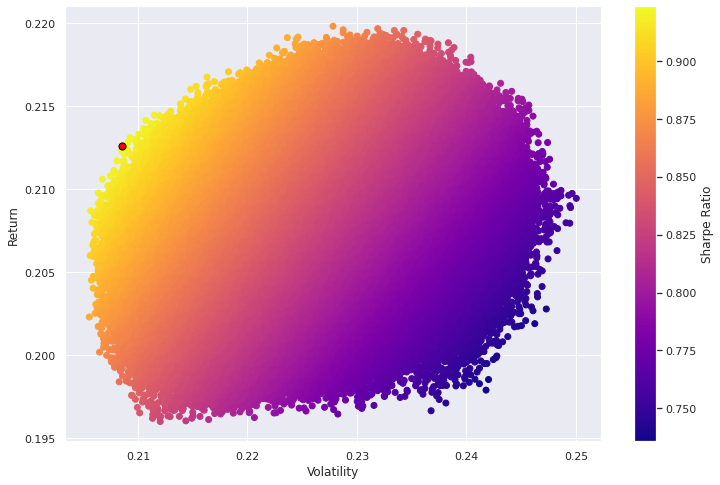

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(Variance, Returns, c=Sharpe, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add red dot for max SR
plt.scatter(optimal_sr_vol_sim, optimal_sr_return_sim, c='red', s=50, edgecolors='black')

### Backtest

In [34]:
[Portfolio_returns_list,Portfolio_weights_historical,BenchmarkReturns]=backtest_Optimizer(Portfolio_Tickers,Sector_Constraints,Benchmark="SP500",n=100000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Running Simulation Now:--->

epoch 0/100000: Complete
epoch 10000/100000: Complete
epoch 20000/100000: 

2.4712231371311923 1.173787024933258
128
[0, 0.027304560797629662, 0.039787344672045144, 0.030851475632995395, -0.0075256995449883846, -0.0646993081586249, 0.03879271987370014, 0.01251888494028286, 0.019570609701871078, 0.02394711879625433, -0.0199878423580504, 0.0028426724604573295, 0.007043368100712932, 0.04919779199874608, 0.010999927126354336, 0.03535529432970552, 0.017924165836651795, 0.020550202383511795, -0.015112928770280476, 0.048277728051788316, -0.03179826803794494, 0.029315591366424698, 0.04362997111283384, 0.027663289773235178, 0.023289474482053762, -0.036231407776019076, 0.04221337507227485, 0.006908248426944041, 0.006181643365585465, 0.02081219601335782, 0.018878996713560525, -0.015194687637991144, 0.03696364440798927, -0.015635436105290168, 0.022936398829564553, 0.02423747356330619, -0.0041973842211255885, -0.03153277926642595, 0.05343887632562794, -0.017549197433963215, 0.008484722544634948, 0.010436729675337375, -0.021235558871758542, 0.01954968299001969, -0.064624730

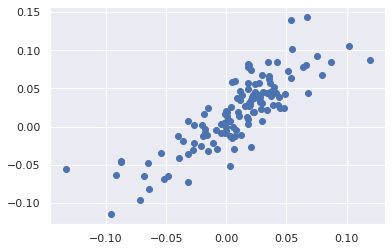

In [35]:
print(sum(Portfolio_returns_list),sum(BenchmarkReturns))
print(len(BenchmarkReturns))
plt.scatter(BenchmarkReturns,Portfolio_returns_list)

print(BenchmarkReturns)

In [36]:
A=np.vstack([BenchmarkReturns,np.ones(len(BenchmarkReturns))]).T
m, c = np.linalg.lstsq(A, Portfolio_returns_list, rcond=None)[0]
print(f"Alpha={c},Beta={m} (Monthly Alpha)")

Alpha=0.010385128371599153,Beta=0.9728568141494254 (Monthly Alpha)
